# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
#Importo las librerias con las que voy a trabajar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.lang.es.examples import sentences
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
import string
from sklearn.metrics import classification_report
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Teniendo en cuenta que los Datasets son de gran tamaño y tardan mucho en cargar, voy a usar el Dataset DEV para la demostracion de todas las transformaciones que hay que realizar y luego voy a importar los DS TRAIN Y TEST en formato CSV con las mismas ya realizadas**

**En el poyecto estan incluidos 3 dataset. DEV / TRAIN /TEST**
**Como algunos DS contienen gran cantidad de datos y demoran en cargarse. voy a realizar el paso a paso del análisis exploratorio sobre DEV y luego voy a importar TRAIN Y TEST ya transformados en formato CSV para su mejor carga**

## Dataset DEV ##

In [2]:
dev = pd.read_json('dataset_es_dev.json', lines = True)
dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [3]:
dev.shape

(5000, 8)

In [4]:
dev.drop_duplicates(inplace = True) #no hay datos duplicados ni faltantes
dev.shape

(5000, 8)

In [5]:
dev.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [6]:
dev.language.value_counts() #solo reseñas en español

es    5000
Name: language, dtype: int64

In [7]:
dev.review_body.shape

(5000,)

In [8]:
dev.stars.value_counts()

4    1000
1    1000
5    1000
2    1000
3    1000
Name: stars, dtype: int64

In [9]:
dev.product_id.value_counts()

product_es_0604475    2
product_es_0589001    2
product_es_0862168    2
product_es_0920931    2
product_es_0066449    2
                     ..
product_es_0573178    1
product_es_0734961    1
product_es_0836861    1
product_es_0953360    1
product_es_0351574    1
Name: product_id, Length: 4964, dtype: int64

In [10]:
dev.reviewer_id.value_counts() 

reviewer_es_0467057    2
reviewer_es_0039406    2
reviewer_es_0301272    2
reviewer_es_0024641    2
reviewer_es_0072551    2
                      ..
reviewer_es_0067237    1
reviewer_es_0610521    1
reviewer_es_0554855    1
reviewer_es_0844758    1
reviewer_es_0247598    1
Name: reviewer_id, Length: 4982, dtype: int64

Elijo una instancia al azar y veo el review boby

In [11]:
np.random #.seed(56)
index_random = np.random.randint(0,high = dev.shape[0])
descripcion = dev.iloc[index_random].review_body
print(index_random, descripcion)

2798 Las instruciones no son adecuadas no dicen cómo emparejar el Bluetooth con Windows 10, el manual no están en español, para aquellos que lo compren para emparejar el ratón tiene que oprimir los tres botones principales al mismo tiempo clic derecho, clic izquierdo y rueda central, en Windows aparece el ratón como modo entrada y así se empareja


vemos la estrella con la que califico al producto comprado

In [12]:
print (f'El comprador {index_random}')
print (f'Califico al producto con {dev.iloc[index_random].stars} estrellas' )

print(index_random, dev.iloc[index_random].stars)

El comprador 2798
Califico al producto con 3 estrellas
2798 3


In [13]:
nlp = spacy.load("es_core_news_sm")

In [14]:
doc = nlp (descripcion)

In [15]:
for token in doc:
    print(token.text)

Las
instruciones
no
son
adecuadas
no
dicen
cómo
emparejar
el
Bluetooth
con
Windows
10
,
el
manual
no
están
en
español
,
para
aquellos
que
lo
compren
para
emparejar
el
ratón
tiene
que
oprimir
los
tres
botones
principales
al
mismo
tiempo
clic
derecho
,
clic
izquierdo
y
rueda
central
,
en
Windows
aparece
el
ratón
como
modo
entrada
y
así
se
empareja


**Stopwords**

In [16]:
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)
print (stopwords_spacy)
len(stopwords_spacy)

['estaban', 'intenta', 'mas', 'cuáles', 'intentar', 'sean', 'que', 'usas', 'quien', 'hace', 'tenido', 'hizo', 'segundo', 'tan', 'bien', 'está', 'las', 'éstos', 'todavía', 'antes', 'estoy', 'nuestra', 'voy', 'junto', 'emplear', 'ultimo', 'adrede', 'partir', 'hacen', 'tambien', 'así', 'cuanto', 'nuestros', 'había', 'muchas', 'somos', 'tampoco', 'hago', 'soy', 'señaló', 'fui', 'hacia', 'del', 'ellas', 'mismos', 'largo', 'informo', 'lugar', 'suyas', 'podeis', 'ha', 'intento', 'ante', 'usa', 'nos', 'un', 'algunas', 'algo', 'ciertas', 'he', 'existe', 'buena', 'podría', 'alguna', 'algunos', 'después', 'habían', 'la', 'ya', 'tenemos', 'suya', 'bastante', 'aquélla', 'realizó', 'mios', 'mis', 'lejos', 'final', 'desde', 'qué', 'empleais', 'era', 'sabe', 'sólo', 'si', 'breve', 'delante', 'arribaabajo', 'diferentes', 'sigue', 'trabajamos', 'buen', 'enfrente', 'míos', 'uno', 'intentamos', 'actualmente', 'dejó', 'mio', 'tuya', 'consiguen', 'algún', 'tengo', 'fuimos', 'ampleamos', 'cuánta', 'hubo', 'p

551

Imprimimos las palabras del texto que no son stop words según Spacy

In [17]:
for token in doc:
    if token.is_stop == False:
        print(token)

instruciones
adecuadas
emparejar
Bluetooth
Windows
10
,
manual
español
,
compren
emparejar
ratón
oprimir
botones
principales
clic
derecho
,
clic
izquierdo
y
rueda
central
,
Windows
aparece
ratón
entrada
y
empareja


**Lemmatización**

In [18]:
for token in doc:
    print (token.text, token.lemma_)

Las el
instruciones instrución
no no
son ser
adecuadas adecuar
no no
dicen decir
cómo cómo
emparejar emparejar
el el
Bluetooth Bluetooth
con con
Windows Windows
10 10
, ,
el el
manual manual
no no
están estar
en en
español español
, ,
para para
aquellos aquel
que que
lo él
compren comprir
para para
emparejar emparejar
el el
ratón ratón
tiene tener
que que
oprimir oprimir
los el
tres tres
botones botón
principales principal
al al
mismo mismo
tiempo tiempo
clic clic
derecho derecho
, ,
clic clic
izquierdo izquierdo
y y
rueda rueda
central central
, ,
en en
Windows Windows
aparece aparecer
el el
ratón ratón
como como
modo modo
entrada entrado
y y
así así
se él
empareja emparejar


**POS Part of Speech**

In [19]:
for token in doc:
    print (token.text, token.pos_)

Las DET
instruciones NOUN
no ADV
son AUX
adecuadas VERB
no ADV
dicen VERB
cómo PRON
emparejar VERB
el DET
Bluetooth PROPN
con ADP
Windows PROPN
10 NUM
, PUNCT
el DET
manual NOUN
no ADV
están AUX
en ADP
español NOUN
, PUNCT
para ADP
aquellos PRON
que PRON
lo PRON
compren VERB
para ADP
emparejar VERB
el DET
ratón NOUN
tiene VERB
que SCONJ
oprimir VERB
los DET
tres NUM
botones NOUN
principales ADJ
al ADP
mismo DET
tiempo NOUN
clic VERB
derecho ADJ
, PUNCT
clic NOUN
izquierdo ADJ
y CCONJ
rueda NOUN
central ADJ
, PUNCT
en ADP
Windows PROPN
aparece VERB
el DET
ratón NOUN
como SCONJ
modo NOUN
entrada ADJ
y CCONJ
así ADV
se PRON
empareja VERB


**Tokenización**

Eliminamos los signos 

In [20]:
puntua = string.punctuation + '¿!¡? + " "'
puntua

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¿!¡? + " "'

In [21]:
def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ !='-PRON-':
            temp = token.lemma_.lower().strip()
        else:
             temp = token.lower_
        tokens.append(temp)
            
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords_spacy and token not in puntua:
            cleaned_tokens.append(token)
            
    return " ".join(cleaned_tokens)

In [22]:
text_data_cleaning (descripcion)

'instrución adecuar emparejar bluetooth windows 10 manual español comprir emparejar ratón oprimir botón principal clic derecho clic izquierdo y rueda central windows aparecer ratón entrado y emparejar'

Aplicamos un text data cleaning sobre review body en todo el dataset y lo imprimimos

In [23]:
dev.review_body.apply(text_data_cleaning)

0          malisimo grande aparatoso y protector pantalla
1                               recibir pedido devolución
2       buscar sistema funcionar abrazadera agarrar ma...
3       utilicé broca menor diámetro y doblar mantequi...
4                      gustar olor a viejo y aspecto malo
                              ...                        
4995    encantar cesta llegar impecable tamaño util fi...
4996                     desempeñar función correctamente
4997    encantar diadema flor venir imagen y venir apl...
4998    a gustar funda tpu fundas normalmente fino y c...
4999                  artículo cumplir expectativa desear
Name: review_body, Length: 5000, dtype: object

In [24]:
dev.head(3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports


In [25]:
dev['review_body']= dev.review_body.apply(text_data_cleaning)

In [26]:
dev

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,malisimo grande aparatoso y protector pantalla,Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,recibir pedido devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,buscar sistema funcionar abrazadera agarrar ma...,Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,utilicé broca menor diámetro y doblar mantequi...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,gustar olor a viejo y aspecto malo,No me gusta,es,beauty
...,...,...,...,...,...,...,...,...
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,encantar cesta llegar impecable tamaño util fi...,guadalupe,es,home
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,desempeñar función correctamente,calidad precio,es,camera
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,encantar diadema flor venir imagen y venir apl...,Excelente,es,toy
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,a gustar funda tpu fundas normalmente fino y c...,Genial,es,wireless


**Importamos el DS desde un csv con los datos de Review body y review title modificados**

In [27]:
dataset_dev = pd.read_csv('dataset_dev.csv') 
dataset_dev.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,es_0417480,product_es_0873923,reviewer_es_0672978,1,malisimo grande aparatoso y protector pantalla,malo compro,es,wireless
1,1,es_0180432,product_es_0713146,reviewer_es_0100858,1,recibir pedido devolución,recibir,es,apparel
2,2,es_0144850,product_es_0356874,reviewer_es_0486447,1,buscar sistema funcionar abrazadera agarrar ma...,apretar manillar,es,sports
3,3,es_0339629,product_es_0939832,reviewer_es_0894703,1,utilicé broca menor diámetro y doblar mantequi...,Brocas mantequilla,es,home_improvement
4,4,es_0858362,product_es_0489066,reviewer_es_0887663,1,gustar olor a viejo y aspecto malo,gustar,es,beauty


## **Importo los datos ya transformados de TRAIN Y TEST en formato csv**

In [28]:
dataset_train = pd.read_csv('dataset_train.csv') 
dataset_train.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,es_0491108,product_es_0296024,reviewer_es_0999081,1,kar pantalla 8 mes y recibir respuesta fabricante,television Nevir,es,electronics
1,1,es_0869872,product_es_0922286,reviewer_es_0216771,1,horrible comprar inglés informático hora capaz...,Dinero tirado a basura compro,es,electronics
2,2,es_0811721,product_es_0474543,reviewer_es_0929213,1,obligar a comprar unidad y llegar y forma recl...,llegar unidad obligar a comprar,es,drugstore
3,3,es_0359921,product_es_0656090,reviewer_es_0224702,1,entrar descalificar vendedor mes espera .... s...,PRODUCTO RECIBIDO,es,wireless
4,4,es_0068940,product_es_0662544,reviewer_es_0224827,1,llegar y co talla equivocado,Devuelto,es,shoes


In [29]:
dataset_test = pd.read_csv('dataset_test.csv') 
dataset_test.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,es_0038754,product_es_0113523,reviewer_es_0580071,1,llegar articulo mandar correo normal seguimien...,llegar,es,wireless
1,1,es_0748979,product_es_0017036,reviewer_es_0819733,1,mensajería horrible compro,amazon seguir cumplir entrega,es,home
2,2,es_0411746,product_es_0138642,reviewer_es_0508607,1,decepcionado vendedor pedido llegar a y cumpli...,ESTAFA envío,es,toy
3,3,es_0786686,product_es_0170887,reviewer_es_0491157,1,valoración producto amazon ofreceis producto a...,Estafa Amazon,es,home
4,4,es_0429700,product_es_0710642,reviewer_es_0008745,1,interés libro y probar versión kindle abrir po...,conseguí pasar portada Kindle,es,digital_ebook_purchase


In [30]:
dataset_test.shape

(5000, 9)

**Como el DS TRAIN contiene una gran cantidad de datos, vamos a tomar una muestra del mismo para su análisis, luego evaluaremos sobre todo el dataset**

In [31]:
dataset_train_dos = dataset_train.sample( n= 1000, weights=np.ones(dataset_train.shape[0]), random_state = 42)
dataset_train_dos

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
74908,74908,es_0101647,product_es_0450032,reviewer_es_0608549,2,embalar retrasar,venir sucio,es,home
190142,190142,es_0302856,product_es_0907235,reviewer_es_0714115,5,regalamos a sobrina 12 año fan serie encantar ...,regalo,es,jewelry
146398,146398,es_0948829,product_es_0063764,reviewer_es_0178095,4,correa tardar llegar a merecer pena,NaN,es,sports
119731,119731,es_0065556,product_es_0845916,reviewer_es_0636981,3,probar quitar punto negro probé farmacia y noche,NaN,es,beauty
31203,31203,es_0009633,product_es_0155896,reviewer_es_0229708,1,quedar satisfecho modelo 2019 y especifique fu...,Funda y movil incompatible,es,home
...,...,...,...,...,...,...,...,...,...
27363,27363,es_0078673,product_es_0270175,reviewer_es_0358567,1,poner él evitar presencia mota y fácil instala...,recomendable,es,wireless
190047,190047,es_0144389,product_es_0785813,reviewer_es_0369290,5,perfecta niño y adolescente ocupar espacio y c...,Perfecta,es,furniture
89201,89201,es_0805021,product_es_0167570,reviewer_es_0114986,3,irritar piel crema,a piel funcionar,es,beauty
37053,37053,es_0680350,product_es_0790523,reviewer_es_0367273,1,compro y venir rueda eje querer devolver él pe...,esperar respuesta Amazon comentario,es,lawn_and_garden


In [32]:
dataset_train.stars.value_counts()

1    40000
2    40000
3    40000
4    40000
5    40000
Name: stars, dtype: int64

In [33]:
dataset_train_dos.stars.value_counts()

1    225
5    199
2    196
3    193
4    187
Name: stars, dtype: int64

**Benchmark**

**Vectorización TF-IDF**

Tomamos X del DS train y del DS dev y comparamos su desempeño sobre **Review_body**

In [34]:
tfidf_body = TfidfVectorizer (analyzer = 'word', max_features = 1000)
X_ds_train_body = tfidf_body.fit_transform(dataset_train_dos['review_body'].values.astype('U')) 
y_ds_train_body = dataset_train_dos ['stars']

In [35]:
X_ds_dev_body = tfidf_body.transform(dataset_dev['review_body'].values.astype('U')) 
y_ds_dev_body = dataset_dev['stars']

In [36]:
y_ds_train_body

74908     2
190142    5
146398    4
119731    3
31203     1
         ..
27363     1
190047    5
89201     3
37053     1
108388    3
Name: stars, Length: 1000, dtype: int64

**OVO - One vs One Classifier**

In [37]:
modelo_train= OneVsOneClassifier(LinearSVC(random_state = 42)).fit(X_ds_train_body,y_ds_train_body)
y_dev_pred= modelo_train.predict(X_ds_dev_body)

In [38]:
modelo_train

OneVsOneClassifier(estimator=LinearSVC(random_state=42))

In [39]:
y_dev_pred

array([2, 1, 4, ..., 4, 5, 4], dtype=int64)

In [40]:
print(classification_report(y_ds_dev_body, y_dev_pred))

              precision    recall  f1-score   support

           1       0.42      0.52      0.47      1000
           2       0.26      0.27      0.27      1000
           3       0.27      0.27      0.27      1000
           4       0.29      0.26      0.27      1000
           5       0.43      0.37      0.40      1000

    accuracy                           0.34      5000
   macro avg       0.34      0.34      0.34      5000
weighted avg       0.34      0.34      0.34      5000



Vectorizamos **Review_title**

In [41]:
tfidf_title = TfidfVectorizer (analyzer = 'word', max_features = 1000)
X_ds_train_title = tfidf_title.fit_transform(dataset_train_dos['review_title'].values.astype('U')) 
y_ds_train_body = dataset_train_dos ['stars']

In [42]:
X_ds_dev_title = tfidf_title.transform(dataset_dev['review_title'].values.astype('U')) 
y_ds_dev_body = dataset_dev['stars']

**Concatenamos review body y review title**

In [43]:
X_train_bt = sparse.hstack((X_ds_train_body, X_ds_train_title))
X_dev_bt =sparse.hstack((X_ds_dev_body, X_ds_dev_title))

**Random Forest Classifier**

In [44]:
modelo_train_rf= OneVsOneClassifier(RandomForestClassifier(random_state = 42)).fit(X_train_bt, y_ds_train_body)
y_dev_pred_rf= modelo_train_rf.predict(X_dev_bt)

In [45]:
print(classification_report(y_ds_dev_body, y_dev_pred_rf))

              precision    recall  f1-score   support

           1       0.47      0.60      0.52      1000
           2       0.28      0.19      0.23      1000
           3       0.27      0.43      0.33      1000
           4       0.35      0.19      0.25      1000
           5       0.48      0.41      0.44      1000

    accuracy                           0.37      5000
   macro avg       0.37      0.37      0.35      5000
weighted avg       0.37      0.37      0.35      5000



In [46]:
modelo_train_scv= OneVsOneClassifier(LinearSVC(random_state = 42)).fit(X_train_bt,y_ds_train_body)
y_dev_pred_scv= modelo_train_scv.predict(X_dev_bt)

In [47]:
print(classification_report(y_ds_dev_body, y_dev_pred_scv))

              precision    recall  f1-score   support

           1       0.46      0.55      0.50      1000
           2       0.30      0.29      0.30      1000
           3       0.29      0.30      0.29      1000
           4       0.31      0.28      0.29      1000
           5       0.48      0.43      0.45      1000

    accuracy                           0.37      5000
   macro avg       0.37      0.37      0.37      5000
weighted avg       0.37      0.37      0.37      5000



**Hiperparametros con Random Forest**

In [48]:
n_estimators_list = [50,100,150]
max_depth_list = [150,300,350]

best_n_estimators = None 
best_max_depth = None

best_accuracy = 0
combinations = [(n_estimators, max_depth)for n_estimators in n_estimators_list for max_depth in max_depth_list]

for n_estimators, max_depth in combinations:
    modelo_train_mx = OneVsOneClassifier(RandomForestClassifier(random_state = 42,n_estimators = n_estimators, max_depth = max_depth))
    modelo_train_mx.fit(X_ds_train_title, y_ds_train_body)
    y_dev_pref_mx = modelo_train_mx.predict (X_ds_dev_title)

    current_accuracy = accuracy_score (y_ds_dev_body, y_dev_pred_rf)
    if current_accuracy >= best_accuracy:
        best_accuracy = current_accuracy,
        best_n_estimators =n_estimators,
        best_max_depth = max_depth
        
print (best_accuracy, best_n_estimators, best_max_depth)



(0.3654,) (150,) 350


In [49]:
print (best_accuracy, best_n_estimators, best_max_depth)

(0.3654,) (150,) 350


**Hiperparametros con SVC**

In [50]:
max_c = [0.5,1,2,3,3.5]
max_penalty = ['l2']

best_c = None 
best_penalty = None

mejor_accuracy = 0
combinations = [(C, penalty)for C in max_c for penalty in max_penalty]

for C, penalty in combinations:
    modelo_train_svc = OneVsOneClassifier(LinearSVC(C = C,  penalty = penalty))
    modelo_train_svc.fit(X_ds_train_title, y_ds_train_body)
    y_dev_pred_svc = modelo_train_svc.predict (X_ds_dev_title)

    current_accuracy_svc = accuracy_score (y_ds_dev_body, y_dev_pred_svc)
    if current_accuracy_svc >= mejor_accuracy:
        mejor_accuracy = current_accuracy_svc,
        best_c = C
        best_penalty = penalty
        
print (mejor_accuracy, best_c, best_penalty)

(0.323,) 2 l2


**Importamos los DS de TRAIN y TEST y los preparamos para evaluar** 

In [51]:
ds_test = pd.read_csv('dataset_test.csv') 
ds_test.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,es_0038754,product_es_0113523,reviewer_es_0580071,1,llegar articulo mandar correo normal seguimien...,llegar,es,wireless
1,1,es_0748979,product_es_0017036,reviewer_es_0819733,1,mensajería horrible compro,amazon seguir cumplir entrega,es,home
2,2,es_0411746,product_es_0138642,reviewer_es_0508607,1,decepcionado vendedor pedido llegar a y cumpli...,ESTAFA envío,es,toy
3,3,es_0786686,product_es_0170887,reviewer_es_0491157,1,valoración producto amazon ofreceis producto a...,Estafa Amazon,es,home
4,4,es_0429700,product_es_0710642,reviewer_es_0008745,1,interés libro y probar versión kindle abrir po...,conseguí pasar portada Kindle,es,digital_ebook_purchase


In [52]:
ds_train = pd.read_csv('dataset_train.csv') 
ds_train.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,es_0491108,product_es_0296024,reviewer_es_0999081,1,kar pantalla 8 mes y recibir respuesta fabricante,television Nevir,es,electronics
1,1,es_0869872,product_es_0922286,reviewer_es_0216771,1,horrible comprar inglés informático hora capaz...,Dinero tirado a basura compro,es,electronics
2,2,es_0811721,product_es_0474543,reviewer_es_0929213,1,obligar a comprar unidad y llegar y forma recl...,llegar unidad obligar a comprar,es,drugstore
3,3,es_0359921,product_es_0656090,reviewer_es_0224702,1,entrar descalificar vendedor mes espera .... s...,PRODUCTO RECIBIDO,es,wireless
4,4,es_0068940,product_es_0662544,reviewer_es_0224827,1,llegar y co talla equivocado,Devuelto,es,shoes


**Aplicamos TF-IDF sobre Review body y review title de cada DS**

In [53]:
tfidf_titulo = TfidfVectorizer (analyzer = 'word', max_features = 1000)
X_test_titulo = tfidf_titulo.fit_transform(ds_test['review_title'].values.astype('U')) 
y_test = ds_test ['stars']

In [54]:
X_train_titulo = tfidf_titulo.transform(ds_train['review_title'].values.astype('U')) 
y_train = ds_train['stars']

In [55]:
X_test_body = tfidf_titulo.fit_transform(ds_test['review_body'].values.astype('U')) 
y_test = ds_test ['stars']

In [56]:
X_train_body = tfidf_titulo.transform(ds_train['review_body'].values.astype('U')) 
y_train = ds_train['stars']

Concatenamos body y title

In [57]:
X_train_concat = sparse.hstack((X_train_titulo, X_train_body))
X_test_concat =sparse.hstack((X_test_titulo, X_test_body))

In [58]:
X_train_concat

<200000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1645078 stored elements in COOrdinate format>

In [59]:
X_test_concat

<5000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 43142 stored elements in COOrdinate format>

In [60]:
modelo_final = OneVsOneClassifier(RandomForestClassifier(random_state = 42,n_estimators = 150 , max_depth = 350 ))
modelo_final.fit(X_train_concat, y_train)
predi = modelo_final.predict (X_test_concat)
print(accuracy_score (y_test, predi))

0.4838


**Matriz de confusión**

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
lista=[1,2,3,4,5]

def confusion(y_test,predi):
    names= lista
    cm=confusion_matrix(y_test,predi)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

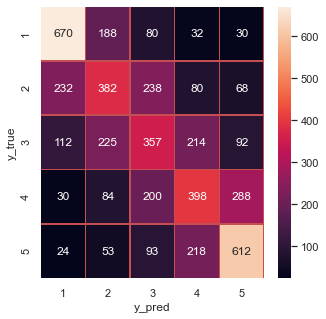

In [62]:
confusion (y_test, predi)

Al graficar la matriz de confusión podemos encontrar 2 bloques dividos: 1/2 y 4/5. se agrupan los positivos y negativos.  Esperaba que midiera mejor la diferencia entre 1 y 2 y entre 4 y 5, pero creo que no es tan grave ya que no esta midiendo el numero 1 como un 5 , sino que se confunde entre los dos bloques (malo y bueno).
Esperaba que el 3 midiera un poco mejor, que separara un poco mas las calificaciones, quizás a futuro podria ajustarse el modelo un poco mas para que mida mejor. 

Como es de esperarse, al comparar los modelos podemos observar que el que mejor mide la exactitud es el OVO con optimización de hiperparametros aplicada.
Al realizar el proyecto, por la cantidad de datos brindados esperaba que el accuracy fuera de un 80%, pero no fue el resultado obtenido. 

A modo de aclaracion; los dataset TRAIN Y TEST se presentan ya transformados en formato CSV para que el trabajo sea más legible en relación a las técnicas y procesos aplicados. Se aplicaron todas las modificaciones (tokenizacion, lematizacion, concatenación tanto para review_body y review_title) y se guardo en archivo CSV por una cuestión de prolijidad y legibilidad del código.

Hago la demostracion de la aplicacion de los codigos aprendidos en el modelo DEV. 
En el caso de que sea necesario, puedo agregar dichas transformaciones al proyecto. 

El proyecto presenta un problema de clasificacion multiclase, en el que me encuentro frente a la premisa de predecir qué estrella le asigna cada usuario a determinada compra en base a sus comentarios. Encontramos 3 dataset con diversa cantidad de datos. Analizo los mismos y los ordeno para poder trabajar con ellos de la manera que considero mas adecuada.

Decido aplicar OVO (one vs one) porque estoy trabajando un problema de multiclases. Luego aplico Random forest y Linear SVC al modelo para poder elegir los hiperparametros mas adecuados para el mismo.

Al realizar el analisis de procesos avanzados como Random Forest y Linear SVC decido evaluar todas las metricas de clasificacion para determinar cual es la que mejor resultado brinda. 

Realizo el analisis de hiperparametros y determino cuales son los mejores para correr el modelo final optimizado. 

A futuro me gustaria ver la incidencia que tiene en el modelo la categoria de productos de los datos. Me gustaria analizar si hay mayor o menor predisposición al alto o bajo puntaje dependiendo de la misma. Tambien se podria realizar un analisis de product_id y reviewer_id para ver con que frecuencia compran y califican los usuarios (seria interesante preguntarnos si hay usuarios "detractores" de productos que suelen calificar mal sin importar el producto obtenido) 

